# 1. Install Dependencies and Setup

This model uses the fresh / non fresh data from ARTEMIS. It is based onthis tutorial [https://www.youtube.com/watch?v=jztwpsIzEGc]  by Nicholas Renotte

In [17]:
import os

In [18]:
import tensorflow as tf

In [19]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [20]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [21]:
import cv2
import imghdr

In [22]:
data_dir = 'freshness_data' 

In [23]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [24]:
for image_class in os.listdir(data_dir): 
    if image_class != ".DS_Store":
        for image in os.listdir(os.path.join(data_dir, image_class)):
            image_path = os.path.join(data_dir, image_class, image)
            try: 
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)
                if tip not in image_exts: 
                    print('Image not in ext list {}'.format(image_path))
                    os.remove(image_path)
            except Exception as e: 
                print('Issue with image {}'.format(image_path))
                # os.remove(image_path)

KeyboardInterrupt: 

# 3. Load Data

In [25]:
import numpy as np
from matplotlib import pyplot as plt

In [27]:
data = tf.keras.utils.image_dataset_from_directory('freshness_data')

Found 1258 files belonging to 2 classes.


In [28]:
data_iterator = data.as_numpy_iterator()

In [29]:
batch = data_iterator.next()

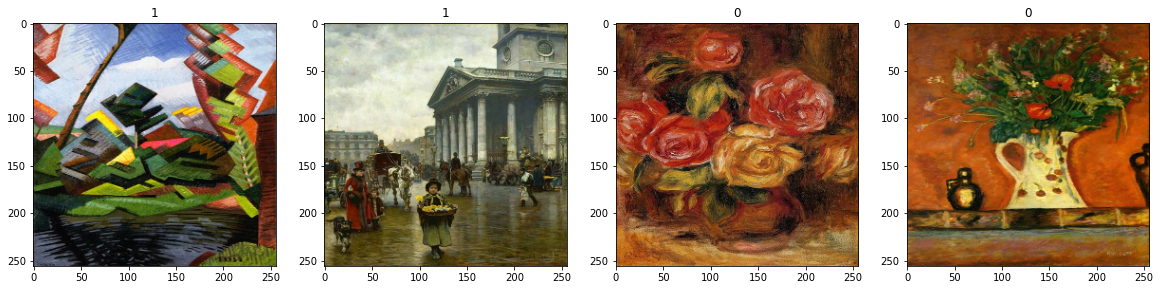

In [30]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [31]:
data = data.map(lambda x,y: (x/255, y))

In [32]:
data.as_numpy_iterator().next()

(array([[[[0.42759266, 0.4766506 , 0.5786114 ],
          [0.43900505, 0.50373006, 0.6053577 ],
          [0.41239277, 0.49872473, 0.60454965],
          ...,
          [0.46760875, 0.66560966, 0.75288373],
          [0.48494178, 0.66074604, 0.75617725],
          [0.49929535, 0.6640012 , 0.76204044]],
 
         [[0.41685814, 0.47779566, 0.57673866],
          [0.40797716, 0.4806794 , 0.5757583 ],
          [0.39969364, 0.49200368, 0.59194624],
          ...,
          [0.46583948, 0.65997624, 0.7490962 ],
          [0.4776616 , 0.6549211 , 0.74517465],
          [0.4881587 , 0.64502144, 0.74306065]],
 
         [[0.41618797, 0.4902995 , 0.584712  ],
          [0.41059282, 0.49646905, 0.5885302 ],
          [0.38362822, 0.48499924, 0.58137256],
          ...,
          [0.4803845 , 0.6754825 , 0.75979626],
          [0.49577588, 0.66342294, 0.75107616],
          [0.49596736, 0.647346  , 0.7399012 ]],
 
         ...,
 
         [[0.07666973, 0.08333334, 0.08295037],
          [0.05137

# 5. Split Data

In [33]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [34]:
train_size

28

In [35]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [36]:
train

<TakeDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [38]:
model = Sequential()

In [39]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [40]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 14400)             0

# 7. Train

In [42]:
logdir='logs'

In [43]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [44]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
28/28 [==============================] - 44s 1s/step - loss: 0.7722 - accuracy: 0.5167 - val_loss: 0.6714 - val_accuracy: 0.5547
Epoch 2/20
28/28 [==============================] - 46s 2s/step - loss: 0.6878 - accuracy: 0.5379 - val_loss: 0.6805 - val_accuracy: 0.5898
Epoch 3/20
28/28 [==============================] - 41s 1s/step - loss: 0.6857 - accuracy: 0.5234 - val_loss: 0.6740 - val_accuracy: 0.6250
Epoch 4/20
28/28 [==============================] - 38s 1s/step - loss: 0.6359 - accuracy: 0.6451 - val_loss: 0.5819 - val_accuracy: 0.7305
Epoch 5/20
28/28 [==============================] - 38s 1s/step - loss: 0.5929 - accuracy: 0.6908 - val_loss: 0.5663 - val_accuracy: 0.7070
Epoch 6/20
28/28 [==============================] - 41s 1s/step - loss: 0.5586 - accuracy: 0.7121 - val_loss: 0.5543 - val_accuracy: 0.7305
Epoch 7/20
28/28 [==============================] - 43s 1s/step - loss: 0.5083 - accuracy: 0.7567 - val_loss: 0.6138 - val_accuracy: 0.6719
Epoch 8/20
28/28 [==

# 8. Plot Performance

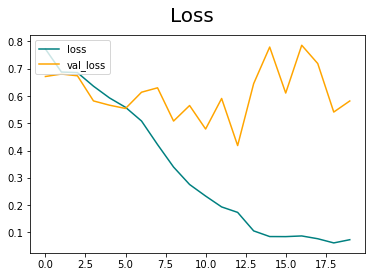

In [45]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

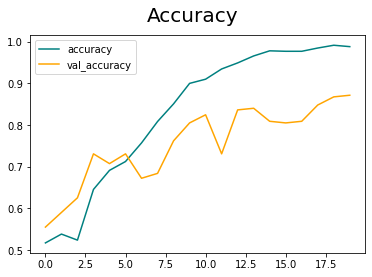

In [46]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [47]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [48]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [53]:
for batch in test.as_numpy_iterator(): 
    X, y = batch # the image and the true value
    yhat = model.predict(X) # the prediction value
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [54]:
print(f'Precision:{pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:0.8106508851051331, Recall: 0.8838709592819214, Accuracy:0.8468749523162842


# 10. Test

In [75]:
import cv2

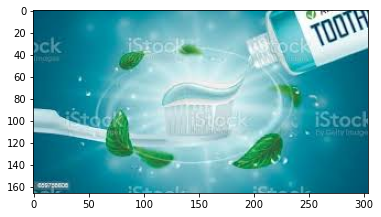

In [76]:
img = cv2.imread('fresh.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

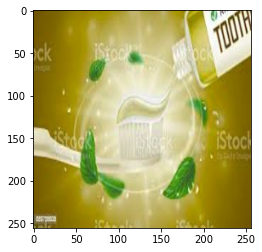

In [79]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [80]:
yhat = model.predict(np.expand_dims(resize/255, 0))
# we do this bc the modele expects a batch of images, not just one

In [70]:
yhat

array([[0.0002996]], dtype=float32)

In [71]:
if yhat > 0.5: 
    print(f'Predicted class is Fresh')
else:
    print(f'Predicted class is Not fresh')

Predicted class is Not fresh


# 11. Save the Model

In [81]:
from tensorflow.keras.models import load_model

In [82]:
model.save(os.path.join('models','imageclassifier.h5'))
#we are saving the model, serializing it (sort of like zipping it)


In [85]:
new_model = load_model('models/imageclassifier.h5')

In [88]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

In [90]:
if yhatnew > 0.5:
    print(f'Predicted class is Fresh')
else:
    print(f'Predicted class is not fresh')

Predicted class is not fresh
